In [2]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [3]:
# Chemins vers les images et les données CSV
images_path = "C:/Users/user/OneDrive/DATASIENCETEST/PROJET/Data/Update/images/image_train"
X_csv_path = "C:/Users/user/OneDrive/DATASIENCETEST/PROJET/Data/Update/X_train_update.csv"
y_csv_path = "C:/Users/user/OneDrive/DATASIENCETEST/PROJET/Data/Update/Y_train_CVw08PX.csv"

# Chargement des données
X_df = pd.read_csv(X_csv_path)
y_df = pd.read_csv(y_csv_path)

# Assurez-vous que les colonnes 'imageid' et 'productid' sont correctes pour correspondre aux noms de fichiers
X_df['image_path'] = X_df.apply(lambda row: f"image_{row['imageid']}_product_{row['productid']}.jpg", axis=1)


In [4]:
# Encodage des labels en format numérique puis en format one-hot
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_df['prdtypecode'])
y_categorical = tf.keras.utils.to_categorical(y_encoded)


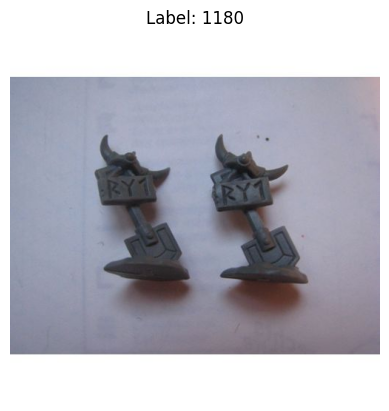

In [5]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# Sélectionner une image aléatoire et afficher avec son label
random_index = random.choice(X_df.index)
random_image_path = os.path.join(images_path, X_df.loc[random_index, 'image_path'])
random_label = y_df.loc[random_index, 'prdtypecode']

img = load_img(random_image_path)
plt.imshow(img)
plt.title(f"Label: {random_label}")
plt.axis('off')
plt.show()


In [6]:
#Création du Modèle CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(y_categorical.shape[1], activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])



C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [7]:
#Configuration de ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


In [8]:
# Vérifiez que la colonne 'prdtypecode' existe dans y_df et ajoutez-la à X_df si nécessaire
if 'prdtypecode' not in X_df.columns and 'prdtypecode' in y_df.columns:
    X_df = X_df.join(y_df['prdtypecode'])  # Ceci est juste un exemple, ajustez selon votre schéma de données


In [9]:
# Vérifiez que la colonne 'prdtypecode' existe dans le DataFrame y_df
if 'prdtypecode' in X_df.columns:
    print("La colonne 'prdtypecode' existe.")
else:
    print("La colonne 'prdtypecode' n'existe pas. Vérifiez le chargement du DataFrame y_df.")


La colonne 'prdtypecode' existe.


In [10]:
# Convertir 'prdtypecode' en string si nécessaire
X_df['prdtypecode'] = X_df['prdtypecode'].astype(str)


Found 1 validated image filenames belonging to 1 classes.


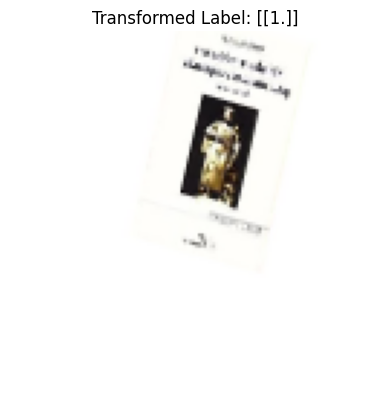

In [11]:
# Appliquer une transformation avec ImageDataGenerator et afficher
augmented_images = datagen.flow_from_dataframe(
    dataframe=X_df.sample(n=1),  # Utiliser une image aléatoire
    directory=images_path,
    x_col='image_path',
    y_col='prdtypecode',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=1
)

# Obtenir la première image du lot et l'afficher
augmented_img, label = next(augmented_images)
plt.imshow(augmented_img[0])
plt.title(f"Transformed Label: {label}")
plt.axis('off')
plt.show()


In [12]:
#Préparation des Générateurs de Données
train_generator = datagen.flow_from_dataframe(
    dataframe=X_df,
    directory=images_path,
    x_col='image_path',
    y_col='prdtypecode',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=X_df,
    directory=images_path,
    x_col='image_path',
    y_col='prdtypecode',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42
)


Found 67933 validated image filenames belonging to 27 classes.
Found 16983 validated image filenames belonging to 27 classes.


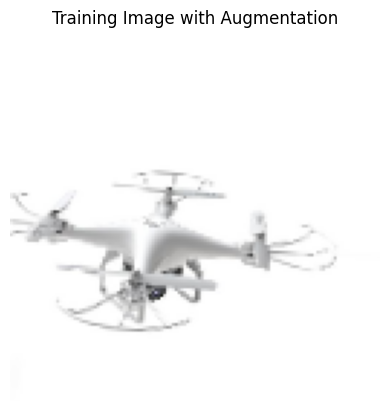

In [13]:
# Afficher une image aléatoire du train_generator
for img_batch, lbl_batch in train_generator:
    plt.imshow(img_batch[0])
    plt.title(f"Training Image with Augmentation")
    plt.axis('off')
    plt.show()
    break  # Nous voulons seulement voir une image, donc nous interrompons la boucle


In [14]:
#Entraînement du Modèle
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size
)


Epoch 1/20


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 1378s 14s/step - accuracy: 0.1106 - loss: 3.3304 - val_accuracy: 0.1326 - val_loss: 3.0755
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.1263 - loss: 3.0789 - val_accuracy: 0.2174 - val_loss: 2.9687
Epoch 3/20


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 1105s 11s/step - accuracy: 0.1402 - loss: 3.0473 - val_accuracy: 0.1406 - val_loss: 3.0225
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.1429 - loss: 2.9969 - val_accuracy: 0.0435 - val_loss: 3.1896
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 487s 5s/step - accuracy: 0.1492 - loss: 2.9799 - val_accuracy: 0.1791 - val_loss: 2.9367
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.1744 - loss: 2.9318 - val_accuracy: 0.1739 - val_loss: 2.8498
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 821s 8s/step - accuracy: 0.1605 - loss: 2.9668 - val_accuracy: 0.1742 - val_loss: 2.8944
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.1712 - loss: 2.9354 - val_accuracy: 0.1304 - val_loss: 2.8882
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1141s 11s/step - accuracy: 0.1882 - loss: 2.8867 - val_accuracy: 0.1824 - val_loss: 2.8589
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.1720 - loss: 2.9102 - val_accuracy: 

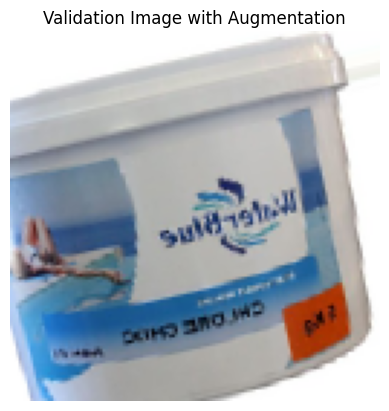

In [15]:
# Afficher une image aléatoire du validation_generator
for img_batch, lbl_batch in validation_generator:
    plt.imshow(img_batch[0])
    plt.title(f"Validation Image with Augmentation")
    plt.axis('off')
    plt.show()
    break  # De nouveau, nous interrompons la boucle après avoir affiché une image


In [16]:
# Évaluation finale sur le jeu de données de validation
eval_result = model.evaluate(validation_generator)
print(f'Loss: {eval_result[0]}, Accuracy: {eval_result[1]}')


531/531 ━━━━━━━━━━━━━━━━━━━━ 224s 421ms/step - accuracy: 0.2204 - loss: 2.7112
Loss: 2.7214744091033936, Accuracy: 0.21839486062526703
